In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

def print_torch_versions():
    """
    Prints the version of torch and torchvision.
    """
    print(torch.__version__)    
    print(torchvision.__version__)


print_torch_versions()


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.13.1
0.14.1


In [67]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [68]:
"""
Load the MNIST dataset for training and testing.
"""
train_mnist = torchvision.datasets.MNIST(
    root="mnist",
    train=True,
    transform=transforms.Compose([transforms.Resize((32,32)),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,), (0.5,))]),
    download=True,
)
test_mnist = torchvision.datasets.MNIST(
    root="mnist",
    train=False,
    transform=transforms.Compose([transforms.Resize((34,32)),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,), (0.5,))]),
    download=True,
)


In [69]:
"""
Get the list of class names from the CIFAR10 training dataset.

Returns:
classnames (list): A list of class names.
"""
classnames = train_mnist.classes

In [70]:
# Hyperparameters

# Number of training epochs
EPOCHS = 20

# Batch size for training
BATCH_SIZE = 32

# Learning Rate
LEARNING_RATE = 1e-3

In [71]:
train_dataloader = torch.utils.data.DataLoader(
    train_mnist, batch_size=BATCH_SIZE, shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_mnist, batch_size=BATCH_SIZE, shuffle=False
)

In [72]:
for images, labels in train_dataloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([32, 1, 32, 32])
Image label dimensions: torch.Size([32])


In [73]:
from libcnn import LeNet5

lenet_model = LeNet5(num_classes=10).to(device)

# define the loss function
loss_fn = torch.nn.CrossEntropyLoss()

# define optmization function
optimizer = torch.optim.Adam(lenet_model.parameters(), lr=0.001)


In [74]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0]*num_epochs
    accuracy_hist_valid = [0]*num_epochs

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct =(torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred,y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()
            loss_hist_valid[epoch] /= len(valid_dl.dataset)
            accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} (train) {accuracy_hist_valid[epoch]:.4f} (valid)')
    
    return loss_hist_train, accuracy_hist_train, loss_hist_valid, accuracy_hist_valid



In [75]:
torch.manual_seed(1)

hist = train(lenet_model, EPOCHS, train_dataloader, test_dataloader)


Epoch 1 accuracy: 0.9457 (train) 0.9814 (valid)
Epoch 2 accuracy: 0.9822 (train) 0.9840 (valid)
Epoch 3 accuracy: 0.9874 (train) 0.9879 (valid)
Epoch 4 accuracy: 0.9899 (train) 0.9872 (valid)
Epoch 5 accuracy: 0.9917 (train) 0.9872 (valid)
Epoch 6 accuracy: 0.9930 (train) 0.9907 (valid)
Epoch 7 accuracy: 0.9936 (train) 0.9885 (valid)
Epoch 8 accuracy: 0.9950 (train) 0.9888 (valid)
Epoch 9 accuracy: 0.9955 (train) 0.9898 (valid)
Epoch 10 accuracy: 0.9956 (train) 0.9892 (valid)
Epoch 11 accuracy: 0.9962 (train) 0.9902 (valid)
Epoch 12 accuracy: 0.9966 (train) 0.9896 (valid)
Epoch 13 accuracy: 0.9967 (train) 0.9881 (valid)
Epoch 14 accuracy: 0.9970 (train) 0.9923 (valid)
Epoch 15 accuracy: 0.9969 (train) 0.9902 (valid)
Epoch 16 accuracy: 0.9974 (train) 0.9892 (valid)
Epoch 17 accuracy: 0.9974 (train) 0.9897 (valid)
Epoch 18 accuracy: 0.9975 (train) 0.9897 (valid)
Epoch 19 accuracy: 0.9976 (train) 0.9890 (valid)
Epoch 20 accuracy: 0.9975 (train) 0.9904 (valid)


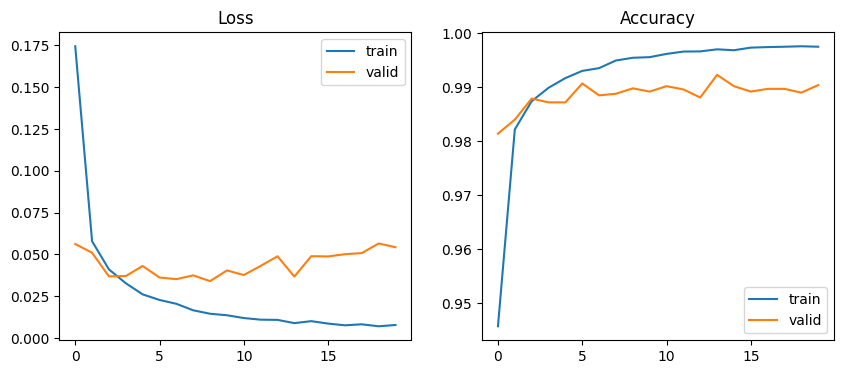

In [76]:
# Write a function to plot a graph for accuracy and loss
import matplotlib.pyplot as plt

def plot_graphs(hist):
    loss_hist_train, accuracy_hist_train, loss_hist_valid, accuracy_hist_valid = hist
    accuracy_hist_train = [x.item() for x in accuracy_hist_train]
    accuracy_hist_valid = [x.item() for x in accuracy_hist_valid]
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.plot(loss_hist_train, label='train')
    plt.plot(loss_hist_valid, label='valid')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.plot(accuracy_hist_train, label='train')
    plt.plot(accuracy_hist_valid, label='valid')
    plt.legend()
    plt.show()

plot_graphs(hist)